### Loading Data

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline
import gdown
# Using https://github.com/wkentaro/gdown

# Define the file IDs
file_ids = [
    '1I1_zbX9aqvl7FaRW1qR36R4PCL7awBlH',
    '1nDk_E5crLPsmLKwq8iykS8s26Xerf_X0'

]

# Define the file names
file_names = [
    'train_catvnoncat.h5',
    'test_catvnoncat.h5'
]

# Download the files
for file_id, file_name in zip(file_ids, file_names):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output=file_name, quiet=False)

# Now, you can use these files
train_dataset = h5py.File('train_catvnoncat.h5', "r")
test_dataset = h5py.File('test_catvnoncat.h5', "r")


print(train_dataset.keys())
print(train_dataset['train_set_x']) # x: images of shape (64,64, 3), X contains 209 images (features)
print(train_dataset['train_set_y']) # y: corresponding boolean values (labels)
print(train_dataset['list_classes']) # we have two classes


Downloading...
From: https://drive.google.com/uc?id=1I1_zbX9aqvl7FaRW1qR36R4PCL7awBlH
To: /content/train_catvnoncat.h5
100%|██████████| 2.57M/2.57M [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nDk_E5crLPsmLKwq8iykS8s26Xerf_X0
To: /content/test_catvnoncat.h5
100%|██████████| 617k/617k [00:00<00:00, 105MB/s]

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>
<HDF5 dataset "train_set_x": shape (209, 64, 64, 3), type "|u1">
<HDF5 dataset "train_set_y": shape (209,), type "<i8">
<HDF5 dataset "list_classes": shape (2,), type "|S7">


In [ ]:
train_X = np.array(train_dataset["train_set_x"][:])
train_Y = np.array(train_dataset["train_set_y"][:])
test_X = np.array(test_dataset["test_set_x"][:]) #  test set features
test_Y = np.array(test_dataset["test_set_y"][:]) #  test set labels
classes = np.array(test_dataset["list_classes"][:])
print(train_X.shape)
print(train_Y.shape)
print(classes.shape)
print(classes) # numpy.bytes_
train_Y = train_Y.reshape((1, train_Y.shape[0]))
test_Y  = test_Y.reshape((1, test_Y.shape[0]))
print(train_Y.shape)


(209, 64, 64, 3)
(209,)
(2,)
[b'non-cat' b'cat']
(1, 209)


1. train_X (209, 64, 64, 3): 209 training iamges, 64 by 64 resolution, three channels RGB.
2. train_Y (1, 209): corresponding labels
3. classes (2,): ASCII codes of classfications "cat" and "non-cat"
4. test_X, test_Y: 50 testing images

### Visualize images in the data set

Some images in the training set

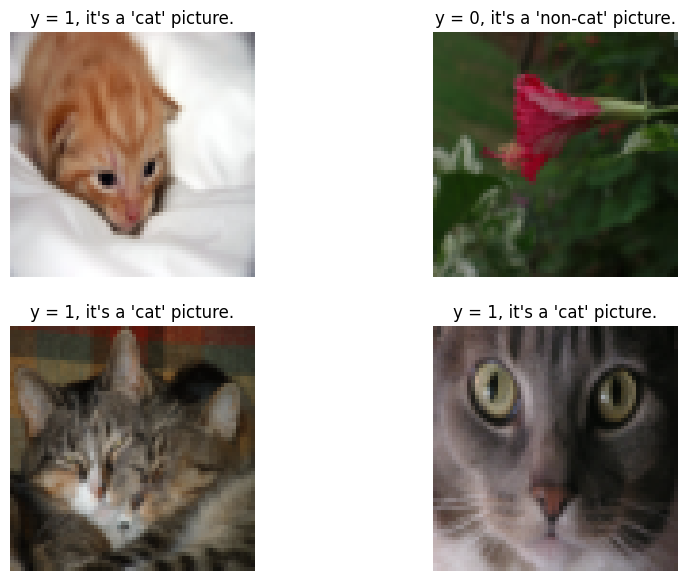

In [ ]:
# the indices of images that we want to look at
indices = [57, 58, 59, 60]

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2

for i in indices:
  fig.add_subplot(rows, columns, i - 56) # i - 56 is the subplot indices, 1,2,3,4
  plt.imshow(train_X[i])
  plt.axis('off')
  plt.title("y = " + str(train_Y[0, i]) + ", it's a '" + classes[np.squeeze(train_Y[:, i])].decode("utf-8") +  "' picture.")

Some images in the testing set

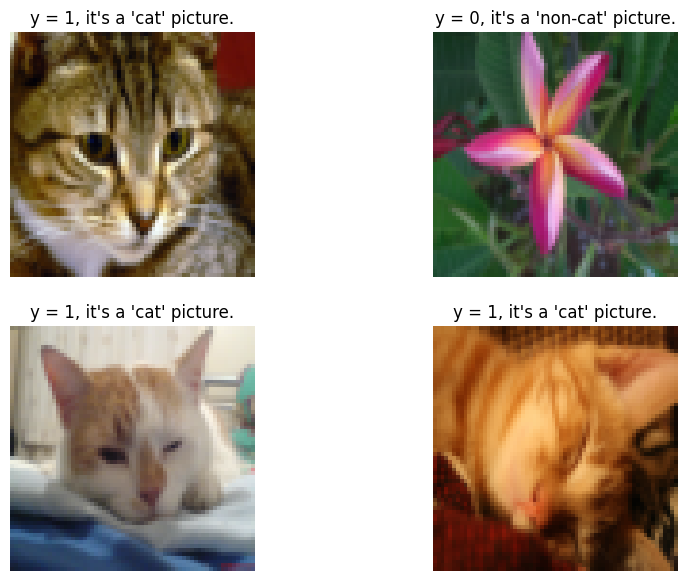

In [ ]:
# the indices of images that we want to look at
indices = [15, 16, 17, 18]

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2

for i in indices:
  fig.add_subplot(rows, columns, i - 14) # i - 54 is the subplot indices, 1,2,3,4
  plt.imshow(test_X[i])
  plt.axis('off')
  plt.title("y = " + str(test_Y[0, i]) + ", it's a '" + classes[np.squeeze(test_Y[:, i])].decode("utf-8") +  "' picture.")

### "Flatten" and normalize the images

Target flat shape:

*   (64 * 64 * 3, m)




In [ ]:
train_X_flat = (train_X.reshape(train_X.shape[0], -1)/255).T  # flatten the image to have a vector, normalize to prevent the calculations from exploding
print(train_X_flat.shape)
test_X_flat = (test_X.reshape(test_X.shape[0], -1)/255).T

(12288, 209)


### Helper Functions

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return: sigmoid(z)
    """
    return 1/(1+np.exp(-z))

In [ ]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    cost -- negative log-likelihood cost for logistic regression
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X) + b)
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m

    cost = np.squeeze(cost)

    return dw, db, cost

## Training

In [ ]:
X = train_X_flat
Y = train_Y
dim = train_X_flat.shape[0]
w = np.zeros((dim,1)) # initialize w, shape (dim, 1)
b = 0 # initialize b, scalar
num_iterations = 10000
learning_rate = 0.006
record_cost = 50  # print out the cost every 50 iterations
costs = []

for i in range(num_iterations):
    dw, db, cost = propagate(w, b, X, Y)


    # gradient descent
    w = w - (learning_rate*dw)
    b = b - (learning_rate*db)

    # Record the costs
    if i % record_cost == 0:
        costs.append(cost)
        print (f"Cost after iteration {i} is: {cost}")

scipy.io.savemat("weights.mat", {"weights":w})
scipy.io.savemat("biases.mat", {"biases":b})

Cost after iteration 0 is: 0.6931471805599453
Cost after iteration 50 is: 0.7281013187730965
Cost after iteration 100 is: 0.6498112732446274
Cost after iteration 150 is: 0.5919060823227436
Cost after iteration 200 is: 0.5383118237783534
Cost after iteration 250 is: 0.4875820528641594
Cost after iteration 300 is: 0.43926169478897475
Cost after iteration 350 is: 0.3932376486927422
Cost after iteration 400 is: 0.3498247654306745
Cost after iteration 450 is: 0.31024837330927285
Cost after iteration 500 is: 0.2784984357971258
Cost after iteration 550 is: 0.2606010237733837
Cost after iteration 600 is: 0.2497640022987191
Cost after iteration 650 is: 0.240093693258189
Cost after iteration 700 is: 0.23117767283922816
Cost after iteration 750 is: 0.2229155289076536
Cost after iteration 800 is: 0.21522905139235482
Cost after iteration 850 is: 0.20805455724093086
Cost after iteration 900 is: 0.20133887003959522
Cost after iteration 950 is: 0.19503682036924938
Cost after iteration 1000 is: 0.18910

## Results

In [ ]:
print(test_X_flat.shape)
w = scipy.io.loadmat('weights.mat')["weights"]
b = scipy.io.loadmat('biases.mat')["biases"]
print(w.shape)
print(b.shape)
A = sigmoid(np.dot(w.T,test_X_flat) + b)
Y_predict_test = (A >= 0.5) * 1.0
Y_predict_train = sigmoid(np.dot(w.T,X) + b)

print(f"train accuracy: {(100 - np.mean(np.abs(Y_predict_train - train_Y)) * 100):2f}")
print(f"test accuracy: {(100 - np.mean(np.abs(Y_predict_test - test_Y)) * 100):2f}")


(12288, 50)
(12288, 1)
(1, 1)
train accuracy: 97.404120
test accuracy: 70.000000


#Writing on My Own

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline
import gdown
from scipy.special import expit

# Using https://github.com/wkentaro/gdown

# Define the file IDs
file_ids = [
    '1I1_zbX9aqvl7FaRW1qR36R4PCL7awBlH',
    '1nDk_E5crLPsmLKwq8iykS8s26Xerf_X0'

]

# Define the file names
file_names = [
    'train_catvnoncat.h5',
    'test_catvnoncat.h5'
]

# Download the files
for file_id, file_name in zip(file_ids, file_names):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output=file_name, quiet=False)

# Now, you can use these files
train_dataset = h5py.File('train_catvnoncat.h5', "r")
test_dataset = h5py.File('test_catvnoncat.h5', "r")

train_X = np.array(train_dataset["train_set_x"][:])
train_Y = np.array(train_dataset["train_set_y"][:])
test_X = np.array(test_dataset["test_set_x"][:])
test_Y = np.array(test_dataset["test_set_y"][:])
classes = np.array(test_dataset["list_classes"][:])
train_Y = train_Y.reshape((1, train_Y.shape[0]))
test_Y  = test_Y.reshape((1, test_Y.shape[0]))


"""
# Reshape and normalize the data
train_X_flat = (train_X.reshape(train_X.shape[0], -1)/255).T  # flatten the image to have a vector, normalize to prevent the calculations from exploding
test_X_flat = (test_X.reshape(test_X.shape[0], -1)/255).T



# Define sigmoid function
def sigmoid(z):
    ###
    #Compute the sigmoid of z

    #Arguments:
    #z -- A scalar or numpy array of any size.

    #Return: sigmoid(z)
    ###
    return 1/(1+np.exp(-z))

# Define propagate function
def propagate(w, b, X, Y):
    ###
    #Implement the cost function and its gradient for the propagation explained above

    #Arguments:
    #w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    #b -- bias, a scalar
    #X -- data of size (num_px * num_px * 3, number of examples)
    #Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    #Return:
    #dw -- gradient of the loss with respect to w, thus same shape as w
    #db -- gradient of the loss with respect to b, thus same shape as b
    #cost -- negative log-likelihood cost for logistic regression
    ###

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X) + b)
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m

    cost = np.squeeze(cost)

    return dw, db, cost




X = train_X_flat
Y = train_Y
dim = train_X_flat.shape[0]

# Initialize weights and bias
w = np.zeros((dim,1)) # initialize w, shape (dim, 1)
b = 0 # initialize b, scalar
num_iterations = 10000
learning_rate = 0.006
record_cost = 50  # print out the cost every 50 iterations

#Model Training
costs = []
for i in range(num_iterations):
    dw, db, cost = propagate(w, b, X, Y)


    # gradient descent
    w = w - (learning_rate*dw)
    b = b - (learning_rate*db)

    # Record the costs
    if i % record_cost == 0:
        costs.append(cost)
        print (f"Cost after iteration {i} is: {cost}")



A = sigmoid(np.dot(w.T,test_X_flat) + b)
Y_predict_test = (A >= 0.5) * 1.0
Y_predict_train = sigmoid(np.dot(w.T,X) + b)

print(f"train accuracy: {(100 - np.mean(np.abs(Y_predict_train - train_Y)) * 100):2f}")
print(f"test accuracy: {(100 - np.mean(np.abs(Y_predict_test - test_Y)) * 100):2f}")
"""



# Reshape and normalize the data
train_X_flat = train_X.reshape(train_X.shape[0], -1).T / 255
test_X_flat = test_X.reshape(test_X.shape[0], -1).T / 255

# Initialize weights and bias
w = np.zeros((train_X_flat.shape[0], 1))
b = 0

# Define sigmoid function
def sigmoid(z):
    return expit(z)

# Define propagate function
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -np.sum((Y*np.log(A) + (1-Y)*np.log(1-A))) / m
    dw = np.dot(X, (A-Y).T) / m
    db = np.sum(A-Y) / m

    return dw, db, cost

# Define model training function
def train_model(X, Y, w, b, num_iterations, learning_rate):
    costs = []
    for i in range(num_iterations):
        dw, db, cost = propagate(w, b, X, Y)

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
            print(f'Cost after iteration {i}: {cost}')

    return w, b, costs

# Train the model
num_iterations = 10000
learning_rate = 0.006
w, b, costs = train_model(train_X_flat, train_Y, w, b, num_iterations, learning_rate)





A = sigmoid(np.dot(w.T,test_X_flat) + b)
Y_predict_test = (A >= 0.5) * 1.0
Y_predict_train = sigmoid(np.dot(w.T,X) + b)

print(f"train accuracy: {(100 - np.mean(np.abs(Y_predict_train - train_Y)) * 100):2f}")
print(f"test accuracy: {(100 - np.mean(np.abs(Y_predict_test - test_Y)) * 100):2f}")


Downloading...
From: https://drive.google.com/uc?id=1I1_zbX9aqvl7FaRW1qR36R4PCL7awBlH
To: /content/train_catvnoncat.h5
100%|██████████| 2.57M/2.57M [00:00<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nDk_E5crLPsmLKwq8iykS8s26Xerf_X0
To: /content/test_catvnoncat.h5
100%|██████████| 617k/617k [00:00<00:00, 91.4MB/s]


Cost after iteration 0: 0.6931471805599453
Cost after iteration 100: 0.6498112732446274
Cost after iteration 200: 0.5383118237783534
Cost after iteration 300: 0.43926169478897475
Cost after iteration 400: 0.3498247654306745
Cost after iteration 500: 0.2784984357971258
Cost after iteration 600: 0.2497640022987191
Cost after iteration 700: 0.23117767283922816
Cost after iteration 800: 0.21522905139235482
Cost after iteration 900: 0.20133887003959522
Cost after iteration 1000: 0.189109561530962
Cost after iteration 1100: 0.17824871723940586
Cost after iteration 1200: 0.16853308291181376
Cost after iteration 1300: 0.1597878387174924
Cost after iteration 1400: 0.15187341507476668
Cost after iteration 1500: 0.1446766125630104
Cost after iteration 1600: 0.13810439358104684
Cost after iteration 1700: 0.13207941912877472
Cost after iteration 1800: 0.12653676617044216
Cost after iteration 1900: 0.1214214655660316
Cost after iteration 2000: 0.11668662340424087
Cost after iteration 2100: 0.1122919

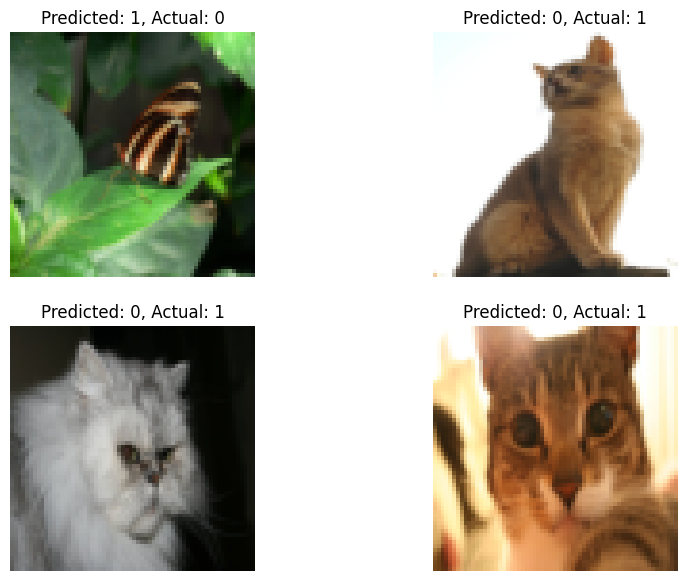

Indices of incorrect predictions: [ 5  6 10 11 13 18 19 28 29 30 33 34 41 44 46]


In [ ]:
# Make predictions on test set
def predict(w, b, X):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    return (A >= 0.5).astype(int)

Y_pred_test = predict(w, b, test_X_flat)

# Find indices of incorrect predictions
incorrect_indices = np.where(Y_pred_test != test_Y)[1]

# Display 4 of the incorrect predictions
num_display = min(4, len(incorrect_indices))

fig = plt.figure(figsize=(10, 7))

for i in range(num_display):
    idx = incorrect_indices[i]
    fig.add_subplot(2, 2, i+1)
    plt.imshow(test_X[idx])
    plt.axis('off')
    plt.title(f'Predicted: {Y_pred_test[0, idx]}, Actual: {test_Y[0, idx]}')

plt.show()

# Report indices of all incorrect predictions
print("Indices of incorrect predictions:", incorrect_indices)


Part 2

Cost after iteration 0: 0.6931471805599453
Cost after iteration 50: 0.6490997333953954
Cost after iteration 100: 0.5564823838352305
Cost after iteration 150: 0.4794800498676364
Cost after iteration 200: 0.4125908598610933
Cost after iteration 250: 0.3581452168043901
Cost after iteration 300: 0.32723207105339247
Cost after iteration 350: 0.3074480759843245
Cost after iteration 400: 0.29017632095429413
Cost after iteration 450: 0.27485645685134097
Cost after iteration 500: 0.26114538427237477
Cost after iteration 550: 0.24878200415685792
Cost after iteration 600: 0.23756289814122405
Cost after iteration 650: 0.22732645614991867
Cost after iteration 700: 0.2179421231291639
Cost after iteration 750: 0.20930290129082899
Cost after iteration 800: 0.20131999415174848
Cost after iteration 850: 0.19391889858146052
Cost after iteration 900: 0.1870364989535662
Cost after iteration 950: 0.18061886934256108
Cost after iteration 1000: 0.17461958545981926
Cost after iteration 1050: 0.1689984098897005

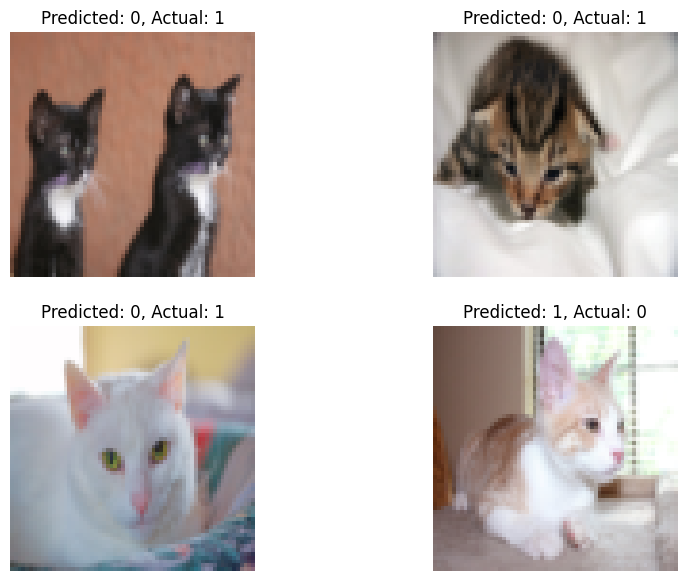

Indices of incorrect predictions in the original test set: [ 0  1  2  4  6  8 10 14 16 19 23 26 27 28 29 31 35 36]


In [ ]:
# Define last digit of ID
last_digit_of_id = 9

# Calculate the number of images to include in the modified training set
num_images_in_train_set = 160 + last_digit_of_id

# Create the modified training set and test set
modified_train_X_flat = train_X_flat[:, :num_images_in_train_set]
modified_train_Y = train_Y[:, :num_images_in_train_set]
modified_test_X_flat = train_X_flat[:, num_images_in_train_set:]
modified_test_Y = train_Y[:, num_images_in_train_set:]

# Set weights and bias for the modified model
w_modified = np.zeros((modified_train_X_flat.shape[0], 1))
b_modified = 0

# Train the model on the modified dataset
num_iterations = 1500
learning_rate = 0.005
w_modified, b_modified, costs_modified = train_model(modified_train_X_flat, modified_train_Y, w_modified, b_modified, num_iterations, learning_rate)

# Make predictions on the modified test set
Y_pred_test_modified = predict(w_modified, b_modified, modified_test_X_flat)

# Calculate training and test accuracies for the modified model
Y_pred_train_modified = predict(w_modified, b_modified, modified_train_X_flat)
train_accuracy_modified = np.mean(Y_pred_train_modified == modified_train_Y) * 100
test_accuracy_modified = np.mean(Y_pred_test_modified == modified_test_Y) * 100

print(f"Modified Training Accuracy: {train_accuracy_modified:.2f}%")
print(f"Modified Test Accuracy: {test_accuracy_modified:.2f}%")

# Find indices of incorrect predictions in the original test set
incorrect_indices_original_test = np.where(Y_pred_test_modified != modified_test_Y)[1]

# Display 4 of these misclassified images from the original test set
num_display_original_test = min(4, len(incorrect_indices_original_test))

fig = plt.figure(figsize=(10, 7))

for i in range(num_display_original_test):
    idx = incorrect_indices_original_test[i]
    fig.add_subplot(2, 2, i+1)
    plt.imshow(test_X[idx])
    plt.axis('off')
    plt.title(f'Predicted: {Y_pred_test_modified[0, idx]}, Actual: {modified_test_Y[0, idx]}')

plt.show()

# Report indices of all incorrect predictions in the original test set
print("Indices of incorrect predictions in the original test set:", incorrect_indices_original_test)
